In [10]:
%cd ~/Code/darknet
!pwd

/home/tm/Code/darknet
/home/tm/Code/darknet


In [17]:
import cv2
import numpy as np
import pandas as pd
import os
import random as rd
from tqdm import tqdm
from PIL import Image, ImageFont, ImageDraw
from matplotlib import pyplot as plt 

rd.seed(31)

def drawbbs(img, label, bbox, gt=False, fontscale=1, thick=1, color=(255,0,0)):
    '''
    bbox = (left, top, right, bottom)
    '''
    assert gt in [False, 'dot', 'solid'], 'gt must be False:bool,\'dot\' or \'solid\''
    bbox = list(map(int,bbox))
    if gt:
        RoundRectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, thick, linestyle=gt)
    else:
        cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, thick)

    fontpath = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"     
    font = ImageFont.truetype(fontpath, 300)
    img_pil = Image.fromarray(img)
    draw = ImageDraw.Draw(img_pil)
    w, h = draw.textsize(label, font=font)
    text_y = bbox[1] - 10
    if text_y<0: text_y=0
    draw.text((bbox[0], text_y), label, font = font, fill = (0,0,0))
    img = np.array(img_pil)
    plt.imshow(img)
    plt.show
    
    # (w,h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_DUPLEX,fontscale,thick)
    # text_y = bbox[1]
    # if (bbox[1]-h)<0:
    #     text_y = bbox[1]+h
    # cv2.putText(img, label, (bbox[0], text_y), cv2.FONT_HERSHEY_DUPLEX,fontscale,(0,0,0),thickness=thick,bottomLeftOrigin=False)

    cv2.rectangle(img,(bbox[0], text_y), (bbox[0]+w,text_y+10), color,-1)
    cv2.rectangle(img,(bbox[0], text_y), (bbox[0]+w,text_y+10), color,thick)
    return img

def RoundRectangle(img, topleft, bottomright, color, thick, linestyle='dot'):
    assert linestyle in ['dot', 'solid'], 'linestyle must be \'dot\' or \'solid\''
    height, width, _ = img.shape
    b_h = int((bottomright[1]-topleft[1])/2)
    b_w = int((bottomright[0]-topleft[0])/2)

    border_radius = int(max([width, height])/30.0)
    r_x = border_radius
    r_y = border_radius
    if border_radius > b_h:
        r_y = b_h
    if border_radius > b_w:
        r_x = b_w

    if linestyle=='solid':
        drline = cv2.line
        drellipsis = cv2.ellipse
    elif linestyle=='dot':
        drline = dotline
        drellipsis = dotellipse

    drline(img, topleft, (bottomright[0]-r_x, topleft[1]), color, thick)#top
    drline(img, (topleft[0]+r_x,bottomright[1]), (bottomright[0]-r_x, bottomright[1]), color, thick)#bottom
    drline(img, topleft, (topleft[0], bottomright[1]-r_y), color, thick)#left
    drline(img, (bottomright[0],topleft[1]+r_y), (bottomright[0],bottomright[1]-r_y), color, thick)#right
    drellipsis(img, (bottomright[0]-r_x, topleft[1]+r_y), (r_x, r_y), 0, 0, -90, color, thick)#top-right
    drellipsis(img, (topleft[0]+r_x, bottomright[1]-r_y), (r_x, r_y), 0, 90, 180, color, thick)#bottom-left
    drellipsis(img, (bottomright[0]-r_x, bottomright[1]-r_y), (r_x, r_y), 0, 0, 90, color, thick)#bottom-right

def dotellipse(img, center, r, rotation, start, end, color, thick):
    dr = int((end-start)/4.5)

    start1 = start
    while np.sign(end-start1)==np.sign(dr):
        end1 = start1+dr
        if np.abs(end-start1)< np.abs(dr):
            end1=end
        cv2.ellipse(img, center, r, rotation, start1, end1, color, thick)
        start1 += 2*dr

def dotline(img, topleft, bottomright, color, thick):
    a = np.sqrt((bottomright[0]-topleft[0])**2+(bottomright[1]-topleft[1])**2)
    if a==0:
        return
    dotgap = max(img.shape[:2])/50
    b = a/dotgap
    dx = int((bottomright[0]-topleft[0])/b)
    dy = int((bottomright[1]-topleft[1])/b)

    x1, y1 = topleft
    while (np.sign(bottomright[0]-x1)==np.sign(dx)) & (np.sign(bottomright[1]-y1)==np.sign(dy)):
        end_x = x1+dx
        end_y = y1+dy

        if np.abs(bottomright[0]-end_x)<np.abs(dx):
            end_x = bottomright[0]
        if np.abs(bottomright[1]-end_y)<np.abs(dy):
            end_y = bottomright[1]
            
        cv2.line(img, (x1, y1), (end_x, end_y), color, thick)
        x1 += 2*dx
        y1 += 2*dy


  0%|          | 0/6 [00:00<?, ?it/s]

{'Crater': (71, 75, 16), 'UBX in Crater': (31, 69, 118), 'UBX': (229, 211, 104)}


100%|██████████| 6/6 [00:06<00:00,  1.07s/it]


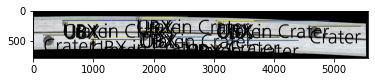

In [19]:
df = pd.read_csv('data/test_perObj_yolov4_final_It0.5_ct0.25_200506-1649.csv', encoding='euc-kr')
gt_bboxes = df.loc[df['id'].notna(), ['img', 'class', 'gt_left', 'gt_top', 'gt_right', 'gt_bottom']].set_index('img')
pred_bboxes = df.loc[df['conf'].notna(), ['img', 'class', 'pred_left', 'pred_top', 'pred_right', 'pred_bottom']].set_index('img')
df_class = df['class'].unique()
class_count = len(df_class)
color = {}
if not os.path.isdir('data/output'):
    os.mkdir('data/output')
for idx, cls in enumerate(df_class):
    color[cls] = (rd.randint(0,256),rd.randint(0,256),rd.randint(0,256))

print(color)
imgs = df['img'].unique()


for img_path in tqdm(imgs):
    img = cv2.imread(img_path)
    fontscale = max(img.shape[:2])/6000
    thick = int(fontscale*3)
    if thick <= 0: thick=1

    for _, val in pred_bboxes.loc[img_path].iterrows():
        img = drawbbs(img, val[0], val.iloc[1:].tolist(),gt=False, fontscale=fontscale, thick=thick, color=color[val[0]])
    cv2.imwrite(f'data/output/{os.path.basename(img_path)}', img)


/home/tm/Code/darknet
/home/tm/Code/darknet
